In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
sns.set()
%matplotlib notebook

In [2]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

# Exploring Data

In [3]:
df = pd.read_csv('taxi_data.csv')
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [8]:
print('Count of Dataframe Elements : {}'.format(df.count()))
print('Columns in Dataframe : ', df.columns)
print('Duplicate Values (Longitude and Latitude): {}'.format(df.duplicated(subset = ['LON', 'LAT']).any()))
print('Null Values : ',df.isna().any())

Count of Dataframe Elements : LON     837
LAT     837
NAME    837
dtype: int64
Columns in Dataframe :  Index(['LON', 'LAT', 'NAME'], dtype='object')
Duplicate Values (Longitude and Latitude): True
Null Values :  LON     True
LAT     True
NAME    True
dtype: bool


In [11]:
# droping Null values and duplicates
print('Original shape of Dataframev : {}'.format(df.shape))
df = df.drop_duplicates(subset=['LON','LAT']).dropna()
print('New Shape after Filtering : {}'.format(df.shape))

Original shape of Dataframev : (838, 3)
New Shape after Filtering : (823, 3)


<IPython.core.display.Javascript object>


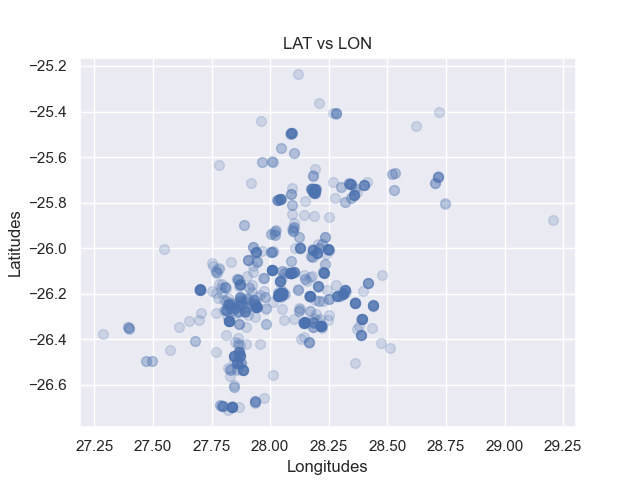

In [20]:
# Plot b/w Lon and Lat
plt.figure()
X = np.array(df[['LON','LAT']], dtype='float64')
plt.scatter(X[:,0],X[:,1],s=50,alpha=0.2)
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
plt.title('LAT vs LON')
plt.show();

# Visualize Geographical Data

#### Plotting map with lats and lons


In [25]:
import folium
import regex as re
m = folium.Map(location=[X[:,1].mean(),X[:,0].mean()],zoom_start=9,tiles = 'Stamen Toner')

for _,row in df.iterrows():
    folium.CircleMarker(
        location = [row.LAT,row.LON],
        radius = 4,
        popup = re.sub(r'[^a-zA-Z ]+',' ',row.NAME),
        color = '#178FFE',
        fill=True,
        fill_colour = '#178FFE'
    ).add_to(m)


In [26]:
m

# Clustering 


In [27]:
# 1. KMeans Cluster
from sklearn.cluster import KMeans
X = np.array(df[['LON','LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k,random_state=17).fit(X)

model_prediction = model.predict(X)
df[f'ClusterMeans{k}'] = model_prediction

In [28]:
df.head()

LON       LAT                          NAME  ClusterMeans70
0  28.17858 -25.73882         11th Street Taxi Rank              15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank              15
2  27.83239 -26.53722          Adams Road Taxi Rank               5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank              33
4  28.10144 -26.10567      Alexandra Main Taxi Rank              18

In [31]:
def create_map(df, col_name):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')
    
    for _,row in df.iterrows():
        if row[col_name] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = colors[row[col_name]]
        
        folium.CircleMarker(
            location = [row.LAT,row.LON],
            radius = 4,
            popup = row[col_name],
            color = cluster_colour,
            fill = True,
            fill_color = cluster_colour
        ).add_to(m)
        
    return m

In [34]:
m_KMeans = create_map(df, 'ClusterMeans70')
m_KMeans

In [35]:
# silhouette score
from sklearn.metrics import silhouette_score

In [38]:
print('Silhouette Score for k = 70 : ', silhouette_score(X,model_prediction))

Silhouette Score for k = 70 :  0.6367300948961482


In [41]:
# Best Silhouette Score
from tqdm import tqdm

for k in tqdm(range(2,100)):
    model = KMeans(n_clusters=k, random_state =0).fit(X)
    model_prediction = model.predict(X)
    
    k_score = silhouette_score(X,model_prediction)
    best_score = -1
    if k_score > best_score:
        K = k
        best_score = k_score
        
print('Best Score for KMeans is for k = {} of {}'.format(K, best_score))
    

100%|██████████| 98/98 [00:21<00:00,  4.58it/s]

Best Score for KMeans is for k = 99 of 0.6994533421669916


In [43]:
# 2. DBSCAN         -           Density-Based Spatial Clustering of Applications with Noise
from sklearn.cluster import DBSCAN                          

model = DBSCAN(eps=0.01, min_samples=5).fit(X)
model_prediction = model.labels_

df['Cluster_DBSCAN'] = model_prediction
df.head()

LON       LAT                          NAME  ClusterMeans70  \
0  28.17858 -25.73882         11th Street Taxi Rank              15   
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank              15   
2  27.83239 -26.53722          Adams Road Taxi Rank               5   
3  28.12514 -26.26666  Alberton City Mall Taxi Rank              33   
4  28.10144 -26.10567      Alexandra Main Taxi Rank              18   

   Cluster_DBSCAN  
0               0  
1               0  
2              -1  
3              -1  
4               1

In [44]:
m_dbscan = create_map(df, 'Cluster_DBSCAN')
m_dbscan

In [49]:
# Visualization
print('No. of Clusters Found : ',len(np.unique(model_prediction)))
print('No. of Outliers Found : ',len(model_prediction[model_prediction == -1]))

print('Silhouette Ignoring Outliers : ',silhouette_score(X[model_prediction != -1], model_prediction[model_prediction != -1]))

#each outlier as Singleton
no_outliers = 0
no_outliers = np.array([(counter+2)*x if x == -1 else x for counter, x in enumerate(model_prediction)])
print('Silhouette Score (Outliers as Singletons) : ',silhouette_score(X,no_outliers))

No. of Clusters Found :  51
No. of Outliers Found :  289
Silhouette Ignoring Outliers :  0.9232138250288208
Silhouette Score (Outliers as Singletons) :  0.5667489350583482


In [53]:
# 3. HDBSCAN - Hierarchical DBSCAN
import hdbscan

model = hdbscan.HDBSCAN(min_cluster_size=5,min_samples=2,cluster_selection_epsilon=0.02)
model_prediction = model.fit_predict(X)

df['Cluster_hdbscan'] = model_prediction

In [54]:
df.head()

LON       LAT                          NAME  ClusterMeans70  \
0  28.17858 -25.73882         11th Street Taxi Rank              15   
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank              15   
2  27.83239 -26.53722          Adams Road Taxi Rank               5   
3  28.12514 -26.26666  Alberton City Mall Taxi Rank              33   
4  28.10144 -26.10567      Alexandra Main Taxi Rank              18   

   Cluster_DBSCAN  Cluster_hdbscan  
0               0               19  
1               0               19  
2              -1               -1  
3              -1               -1  
4               1               49

In [56]:
m_hd = create_map(df,'Cluster_hdbscan')
m_hd        #Less no of Black Circles.. ie Noise Reduced

In [60]:
print(f'Number of clusters found: {len(np.unique(model_prediction))-1}')
print(f'Number of outliers found: {len(model_prediction[model_prediction==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[model_prediction!=-1], model_prediction[model_prediction!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(model_prediction)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 56
Number of outliers found: 92
Silhouette ignoring outliers: 0.6865375368678566
Silhouette outliers as singletons: 0.5742666463700863


In [63]:
# 4. Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters = 3)
model_prediction = model.fit_predict(X)

print('Silhouette Score = ', silhouette_score(X,model_prediction))

Silhouette Score =  0.4266717633165749


In [70]:
# checking best value for n_clusters and linkage
clusters = np.arange(2,100)
linkages = ['ward','average','complete']

for link in linkages:
    for n in tqdm(clusters):
        best_score = -1
        score = silhouette_score(X,AgglomerativeClustering(n_clusters=n, linkage=link).fit_predict(X))
        if score > best_score:
            linkage = link
            n_ = n
            best_score = -1
            
print('Best Linkage is {} with {} clusters with a score of {}'.format(linkage, n_, score))



  0%|          | 0/98 [00:00<?, ?it/s]

  2%|▏         | 2/98 [00:00<00:06, 13.72it/s]

  4%|▍         | 4/98 [00:00<00:06, 13.86it/s]

  6%|▌         | 6/98 [00:00<00:06, 13.76it/s]

  8%|▊         | 8/98 [00:00<00:06, 13.87it/s]

 10%|█         | 10/98 [00:00<00:06, 14.23it/s]

 12%|█▏        | 12/98 [00:00<00:06, 13.20it/s]

 14%|█▍        | 14/98 [00:01<00:06, 13.72it/s]

 16%|█▋        | 16/98 [00:01<00:06, 12.65it/s]

 18%|█▊        | 18/98 [00:01<00:06, 12.75it/s]

 20%|██        | 20/98 [00:01<00:06, 12.72it/s]

 22%|██▏       | 22/98 [00:01<00:05, 12.84it/s]

 24%|██▍       | 24/98 [00:01<00:05, 12.97it/s]

 27%|██▋       | 26/98 [00:01<00:05, 13.07it/s]

 29%|██▊       | 28/98 [00:02<00:05, 13.01it/s]

 31%|███       | 30/98 [00:02<00:05, 13.31it/s]

 33%|███▎      | 32/98 [00:02<00:05, 13.11it/s]

 35%|███▍      | 34/98 [00:02<00:04, 13.31it/s]

 37%|███▋      | 36/98 [00:02<00:04, 13.77it/s]

 39%|███▉      | 38/98 [00:02<00:04, 13.41it/s]

 41%|████      | 40/98 [00:02<0

100%|██████████| 98/98 [00:07<00:00, 13.65it/s]

Best Linkage is complete with 99 clusters with a score of 0.6676204781740604


In [71]:
model_prediction = AgglomerativeClustering(n_clusters=90,linkage='complete').fit_predict(X)
df['Clusters_AC'] = model_prediction
m_AC = create_map(df, 'Clusters_AC')
m_AC

## Dealing With Outliers

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
classifier = KNeighborsClassifier(n_neighbors=1)

df_train = df[df.Cluster_hdbscan != -1]
df_predict = df[df.Cluster_hdbscan == -1]

In [83]:
X_train = np.array(df_train[['LON','LAT']], dtype='float64')
y_train = np.array(df_train['Cluster_hdbscan'])

X_predict = np.array(df_predict[['LON','LAT']],dtype='float64')

In [84]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [85]:
predicts = classifier.predict(X_predict)

In [86]:
df['Cluster_hybrid'] = df['Cluster_hdbscan']

In [89]:
df.loc[df.Cluster_hdbscan == -1, 'Cluster_hybrid'] = predicts

In [90]:
m_hybrid = create_map(df,'Cluster_hybrid')

In [91]:
m_hybrid

In [93]:
class_predictions = df.Cluster_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 56
Silhouette: 0.5480327157972045


In [94]:
# Silhouette Score has decreased.. but now the searching clusters based on density which is good in our case

<IPython.core.display.Javascript object>


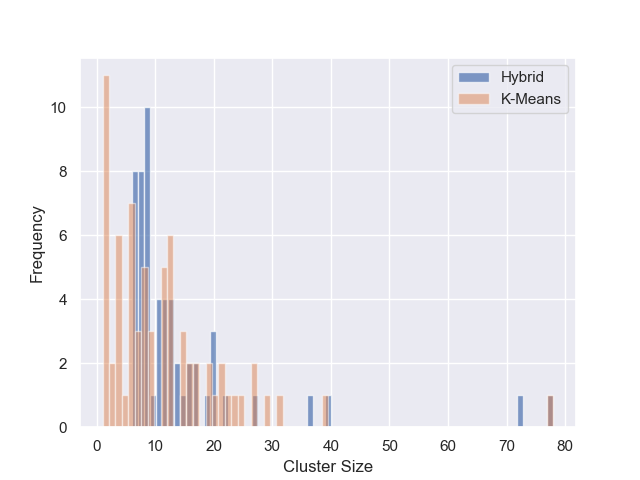

In [115]:
plt.figure()
df['Cluster_hybrid'].value_counts().plot.hist(bins=70, alpha=0.7, label='Hybrid')
df['ClusterMeans70'].value_counts().plot.hist(bins=70, alpha=0.5,label='K-Means')
plt.xlabel('Cluster Size')
plt.legend()
plt.show();